In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

Names and PRN for all group members:
- Name: ______________________
- PRN : ______________________

# Deep Neural Networks 
## A07: Group Assignment


##  Convolutional Neural Network (CNN)

- Flowers Dataset


In [4]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, f1_score)

# from util.helper import * 

    
%matplotlib inline

In [5]:
def fn_plot_tf_hist(hist_df : pd.DataFrame):
    '''
    Note this function is specifically designed to plot Tensorflow training output
    Args:
      hist_df : pandas DataFrame with four columns
                For 'x' values, we will use index
                first column is accuracy
                Second column is loss
                third column is val_accuracy
                fourth column is val_loss
    '''
    fig, axes = plt.subplots(1,2 , figsize = (15,6)) # instantiate plot

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
    
    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y4] == hist_df[y4].min()]
 
    ax = axes[0]

    hist_df.plot(y = [y2,y4], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot
    
    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y4].to_numpy()[0]), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y2.capitalize())
    ax.set_title('Errors')
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y1, y3], ax = ax, colormap=CMAP)
    
    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y3].to_numpy()[0]), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow
    
    
    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()

In [6]:
# Function to plot number of classes in training and testing sets
def fn_plot_label(tr_ds, ts_ds):
    
    '''
        Args:
            tr_ds :  Training Dataset
            ts_ds : Testing dataset
        Returns : none
    '''

    # create figure
    plt.figure(figsize = (15,5))
    
    # create two subplots
    plt.subplot(1,2,1)

    class_names = tr_ds.class_names

    # create array of training labels
    train_labels = tf.concat([y for x, y in tr_ds], axis = 0).numpy()
    
    # get unique labels and counts thereof
    unique, _, counts = tf.unique_with_counts(train_labels)
    
    # bar plot
    plt.bar(range(len(unique)), counts, align='center',color = 'DarkBlue', alpha = 0.7)
    
    # add title
    plt.title('Training Set')
    
    # add ticks on axis
    plt.xticks(range(len(unique)), class_names)
    
    # grids make it look good
    plt.grid()


    #pick second image
    plt.subplot(1,2,2)

    # create array of testing labels 
    val_labels = tf.concat([y for x, y in ts_ds], axis = 0).numpy()
    
    # get unique labels and counts thereof
    unique, _, counts = tf.unique_with_counts(val_labels)
    
    # bar plot
    plt.bar(range(len(unique)), counts, align='center', color = 'Orange', alpha = 0.7)
    
    # add title
    plt.title('Test Set')
    
    # add ticks
    plt.xticks(range(len(unique)), class_names)
    
    # grids make it look good
    plt.grid()
    
    # fit the subplot(s) in to the figure area
    plt.tight_layout()
    
    # display all open figures
    plt.show()

In [7]:
###----------------------
### Some basic parameters
###----------------------

inpDir = 'input' # location where input data is stored
outDir = '../output' # location to store outputs
subDir = 'flower_photos' # location of the images
modelDir = '../models' # location to save model files
valDir = 'valid_flowers' # location related to this dataset
altName = 'students_base_flowers' # Model file name for this alternative

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
tf.random.set_seed(RANDOM_STATE)


EPOCHS = 200   # number of cycles to run
ALPHA = 0.001
BATCH_SIZE = 32
TEST_SIZE = 0.2
IMG_HEIGHT = 188
IMG_WIDTH = 188

# Transformations
# flipping
FLIP_MODE = "horizontal_and_vertical"
# Rotation
ROTATION_FACTOR = (-0.1, 0.1) 
# filling mode
FILL_MODE = 'nearest'


## Early Stopping
ES_PATIENCE = 20 # if performance does not improve stop
# Learning rates
LR_PATIENCE = 10 # if performace is not improving reduce alpha
LR_FACTOR = 0.1 # rate of reduction of alpha


# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (15,8),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }

CMAP = plt.cm.coolwarm

plt.rcParams.update(params) # update rcParams

## Basic Hygiene

In [9]:
###------------------
### Memory Management
###------------------

physical_devices = tf.config.list_physical_devices('GPU') 

if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print (physical_devices)
else:
    print ('Error: No GPU device found')

Error: No GPU device found


## Helper Functions
**Note** all helper functions have been moved to util.helper

## Load Dataset

Images are under flower_photos

     |- daisy
     |- dandelion
     |- roses
     |- sunflowers
     |- tulips

In [12]:
'''
    For reading from web link
'''

#import pathlib
#dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
#data_dir = tf.keras.utils.get_file(origin=dataset_url,
#                                   fname='flower_photos',
#                                   untar=True)
#data_dir = pathlib.Path(data_dir)
'''
    For reading from local directory
'''
data_dir = os.path.join(inpDir, subDir)

In [13]:
data_dir

'input\\flower_photos'

In [14]:
pwd

'C:\\Users\\duasp\\Image processing Neural Network'

In [15]:
# list content of data_dir
os.listdir(data_dir)

['daisy', 'dandelion', 'LICENSE.txt', 'roses', 'sunflowers', 'tulips']

In [16]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=TEST_SIZE,
    subset='training',
    seed= RANDOM_STATE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=TEST_SIZE,
    subset='validation',
    seed= RANDOM_STATE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)


Found 3676 files belonging to 5 classes.
Using 2941 files for training.
Found 3676 files belonging to 5 classes.
Using 735 files for validation.


### Is it picking the class names?

In [18]:
class_names = train_ds.class_names
num_classes = len(class_names)
print('total ', num_classes, class_names)

total  5 ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


### Verify the data

To verify that the dataset looks correct, let's plot the first batch from the training set and display the class name below each image.


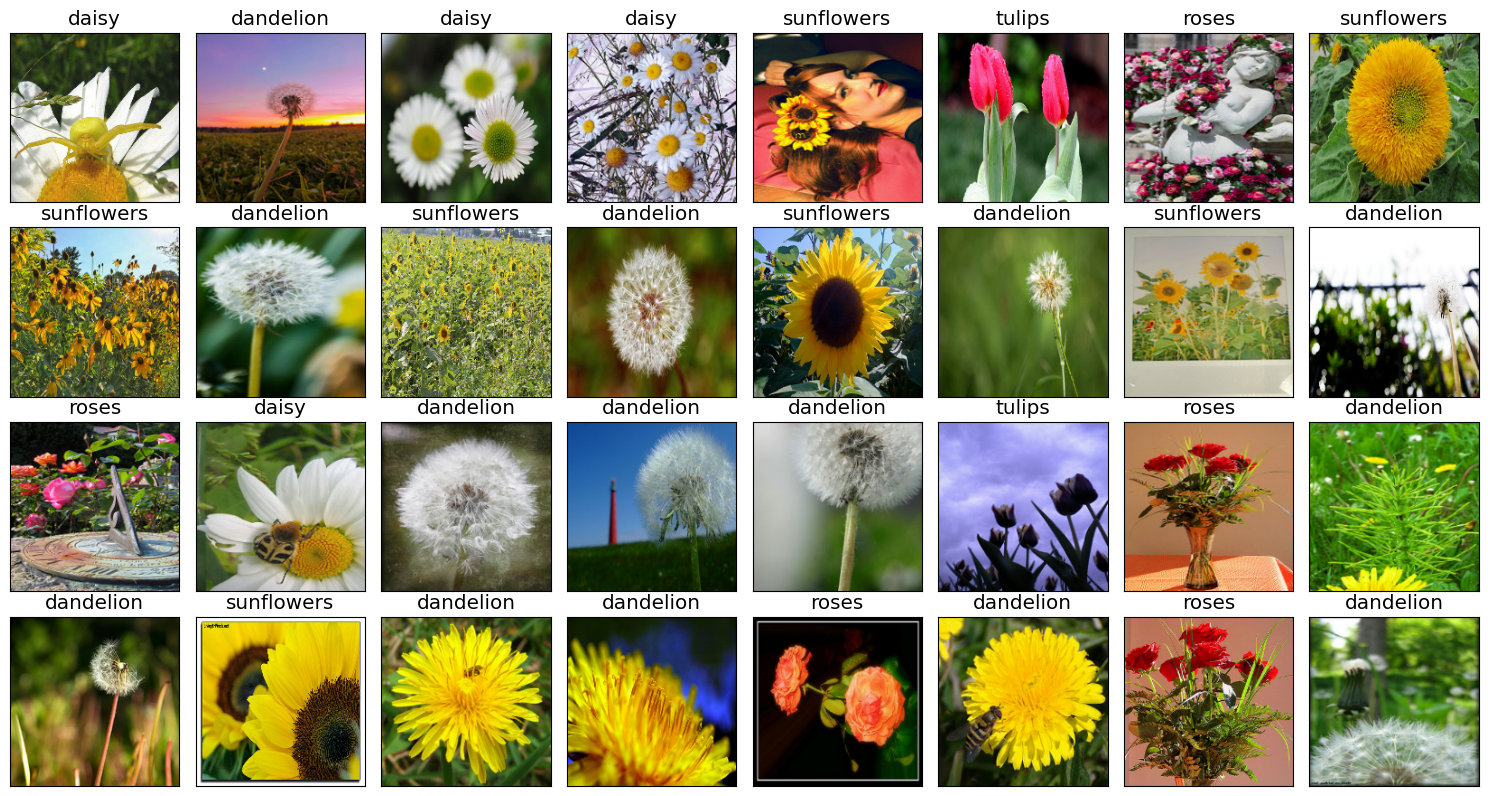

In [20]:
# set figure size
fig = plt.figure()  # figure size in inches with default params

# Adjust the subplot layout parameters.
fig.subplots_adjust(left=0., # as a fraction of the figure width
                    right=1., # use full width, as a fraction of the figure width
                    bottom=0., # as a fraction of the figure height
                    top=1., # as a fraction of the figure height
                    hspace=0.05, # as a fraction of the average Axes height
                    wspace=0.05) # width of the padding between subplots

# take one batch of the dataset
for images, labels in train_ds.take(1):
    
    # iterate through the batch
    for i in range(BATCH_SIZE):
        
        # add a subplot
        ax = fig.add_subplot( BATCH_SIZE//8, 8, (i+1), xticks=[], yticks=[]) # add a subplot to the figure
        
        # image_size may have converted these images to float
        ax.imshow(images[i].numpy().astype("uint8")) 
        
        # display class in the title
        ax.set_title(class_names[labels[i]])
        
# fit the subplot(s) in to the figure area
plt.tight_layout()
    
# display all open images    
plt.show()

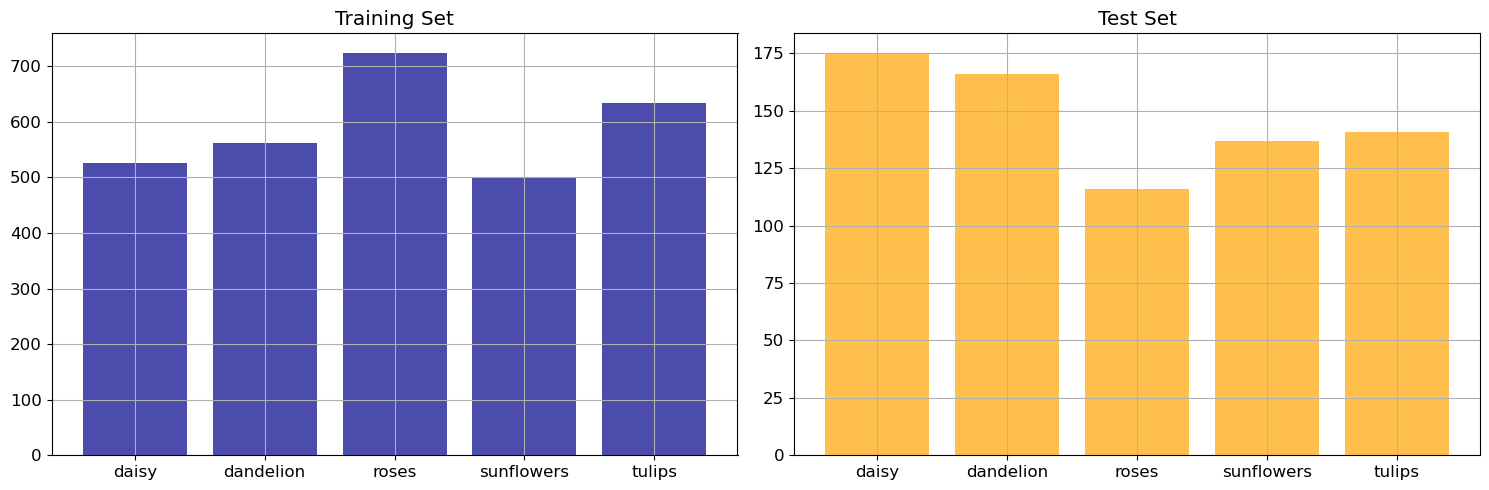

In [21]:
# how many examples in each of the class
fn_plot_label(train_ds, test_ds)

### Data loading efficiency

In [23]:
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE) # cache and prefetch the data
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

### Random Zoom 

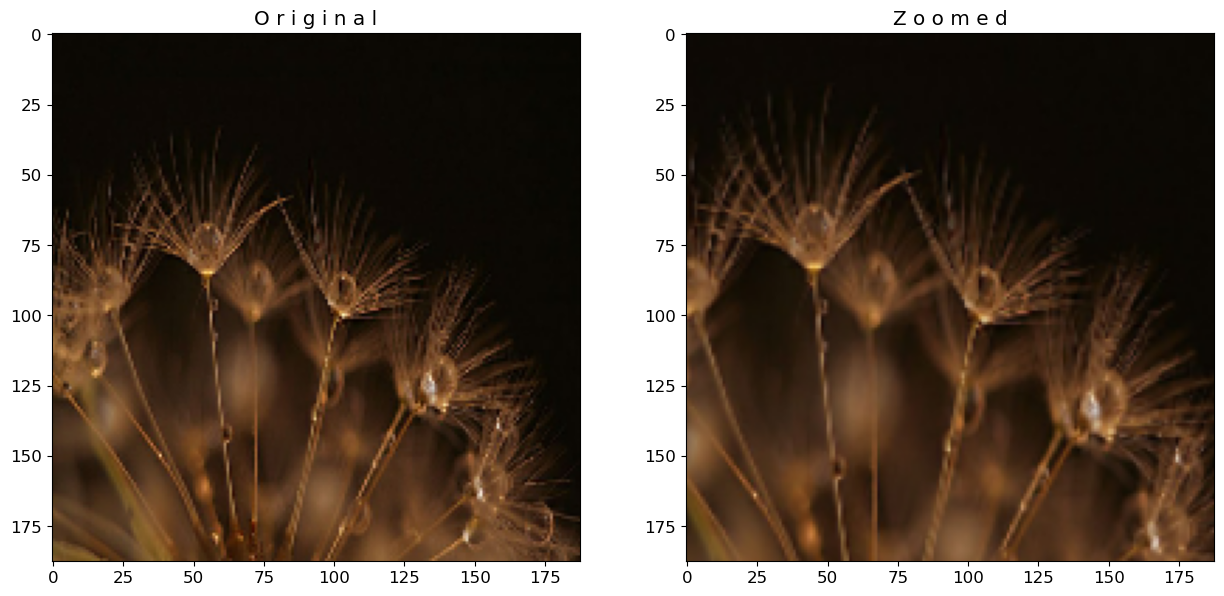

In [25]:
layer = tf.keras.layers.RandomZoom(height_factor=(-0.2, -0.2),
                                   width_factor=(-0.2, -0.2))

plt.figure()
img_num = 3

for imgs, lbls in train_ds.take(1):
    out_imgs = layer(imgs)
    plt.subplot(1,2,1)
    plt.imshow(imgs[img_num].numpy().astype("uint8"))
    plt.title('O r i g i n a l')
    
    plt.subplot(1,2,2)
    plt.imshow(out_imgs[img_num].numpy().astype("uint8"))
    plt.title('Z o o m e d')

### Image Rotation

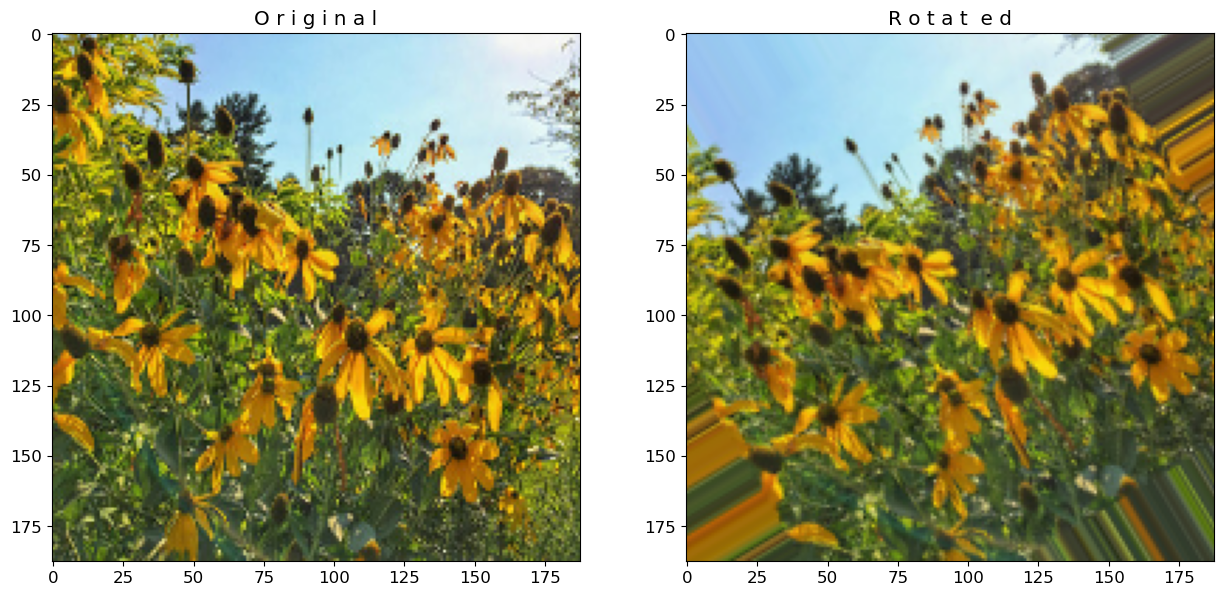

In [27]:
layer = tf.keras.layers.RandomRotation((-0.5, 0.5),fill_mode='nearest')

plt.figure()
img_num = 4

for imgs, lbls in train_ds.take(1):
    out_imgs = layer(imgs)
    plt.subplot(1,2,1)
    plt.imshow(imgs[img_num].numpy().astype("uint8"))
    plt.title('O r i g i n a l')
    
    plt.subplot(1,2,2)
    plt.imshow(out_imgs[img_num].numpy().astype("uint8"))
    plt.title('R o t a t  e d')

## Build Model


In [29]:
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)
knl_init = tf.keras.initializers.GlorotUniform(seed=RANDOM_STATE) # kernel initializer
# Reg 1 : L2 regularization
# knl_reg = tf.keras.regularizers.L2(l2 = 0.005) # kernel regularizer
# Reg 2 : Batch norm + Dropout


model = tf.keras.Sequential(name= 'Flowers') # instantiate the model

model.add(tf.keras.Input(shape=(input_shape), name='Input')) # input layer
model.add(tf.keras.layers.Rescaling(1./255.)) # rescale the image

### Set 1
model.add(tf.keras.layers.Conv2D(64, (3,3), name='Conv1', kernel_initializer=knl_init, padding='same', activation='relu')) 
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=2))

model.add(tf.keras.layers.Conv2D(64, (3,3), name='Conv2', kernel_initializer=knl_init,activation='relu')) 
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=2))

model.add(tf.keras.layers.Conv2D(128, (3,3), name='Conv3', kernel_initializer=knl_init ,activation='relu')) 
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=2))

model.add(tf.keras.layers.Conv2D(256, (3,3), name='Conv4', kernel_initializer=knl_init,activation='relu')) 
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=2))

model.add(tf.keras.layers.Conv2D(512, (3,3), name='Conv5', kernel_initializer=knl_init ,activation='relu')) 

model.add(tf.keras.layers.Conv2D(1024, (3,3), name='Conv6', kernel_initializer=knl_init ,activation='relu')) #

### Head 
model.add(tf.keras.layers.Flatten()) 

##Dense
model.add(tf.keras.layers.Dense(256, kernel_initializer=knl_init))

##Output
model.add(tf.keras.layers.Dense(5))

model.summary()


Model: "Flowers"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 188, 188, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1 (Conv2D)                  │ (None, 188, 188, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 94, 94, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2 (Conv2D)                  │ (None, 92, 92, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv3 (Conv2D)                  │ (None, 44, 44, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv4 (Conv2D)                  │ (None, 20, 20, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv5 (Conv2D)                  │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv6 (Conv2D)                  │ (None, 6, 6, 1024)     │     4,719,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     9,437,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,746,245 (60.07 MB)

 Trainable params: 15,746,245 (60.07 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
filePath = "lstm.keras"
mcb =tf.keras.callbacks.ModelCheckpoint(filePath,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
)
PATIENCE=30
esch =tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=ES_PATIENCE,
    verbose=1,
    restore_best_weights=True,
)

lrch = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=LR_FACTOR,
    patience=LR_PATIENCE,
    verbose=1,
    min_lr=1e-6
)

In [31]:
# Step1: Loss Function
loss_fn =tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
#Step 2 : Optimizer

optimizer = tf.keras.optimizers.Adam(learning_rate=ALPHA)
#Step 3: 
model.compile(loss = loss_fn, optimizer = optimizer, metrics=['accuracy'])

# Step 4 :
history = model.fit(train_ds, 
                    epochs= EPOCHS,
                    callbacks=[mcb,esch, lrch],
                    validation_data=test_ds)

Epoch 1/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 539ms/step - accuracy: 0.2871 - loss: 1.9240
Epoch 1: val_loss improved from inf to 1.24740, saving model to lstm.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 57s 589ms/step - accuracy: 0.2879 - loss: 1.9196 - val_accuracy: 0.4544 - val_loss: 1.2474 - learning_rate: 0.0010
Epoch 2/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 540ms/step - accuracy: 0.4731 - loss: 1.1778
Epoch 2: val_loss improved from 1.24740 to 1.05254, saving model to lstm.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 54s 583ms/step - accuracy: 0.4734 - loss: 1.1774 - val_accuracy: 0.5946 - val_loss: 1.0525 - learning_rate: 0.0010
Epoch 3/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 540ms/step - accuracy: 0.5785 - loss: 1.0506
Epoch 3: val_loss improved from 1.05254 to 0.99760, saving model to lstm.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 53s 582ms/step - accuracy: 0.5787 - loss: 1.0503 - val_accuracy: 0.6272 - val_loss: 0.9976 - learning_rate: 0.0010
Epoch 4/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 547ms/step - accuracy: 0.6169 - loss: 

In [32]:
loss_df = pd.DataFrame(history.history)
loss_df.head()

accuracy      loss  val_accuracy  val_loss  learning_rate
0  0.358722  1.507685      0.454422  1.247404          0.001
1  0.503570  1.137483      0.594558  1.052535          0.001
2  0.594016  1.022220      0.627211  0.997598          0.001
3  0.621897  0.976987      0.606803  1.043280          0.001
4  0.646379  0.916082      0.580952  1.070386          0.001

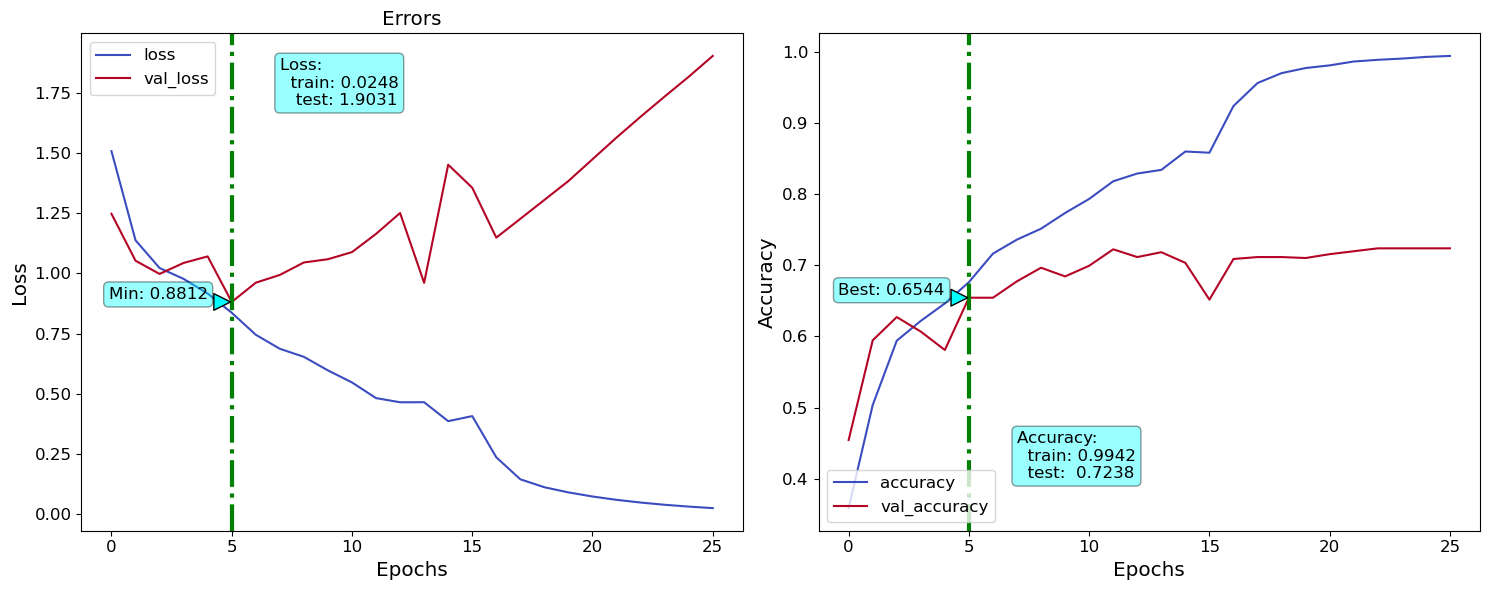

In [33]:
fn_plot_tf_hist(loss_df)

In [34]:
#extract labels from the test dataset
y_test = tf.concat([y for x,y in test_ds], axis=0).numpy()
#make predications output is 
yhat =  model.predict(test_ds)
y_pred = yhat.argmax(axis = 1)
yhat.shape

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step


(735, 5)

In [35]:
print(f'Accuracy: {accuracy_score(y_true=y_test, y_pred=y_pred): .4f}')

Accuracy:  0.6544


In [36]:
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.82      0.65      0.73       141
           1       0.78      0.65      0.71       175
           2       0.36      0.51      0.42       116
           3       0.75      0.83      0.79       137
           4       0.65      0.61      0.63       166

    accuracy                           0.65       735
   macro avg       0.67      0.65      0.65       735
weighted avg       0.68      0.65      0.66       735



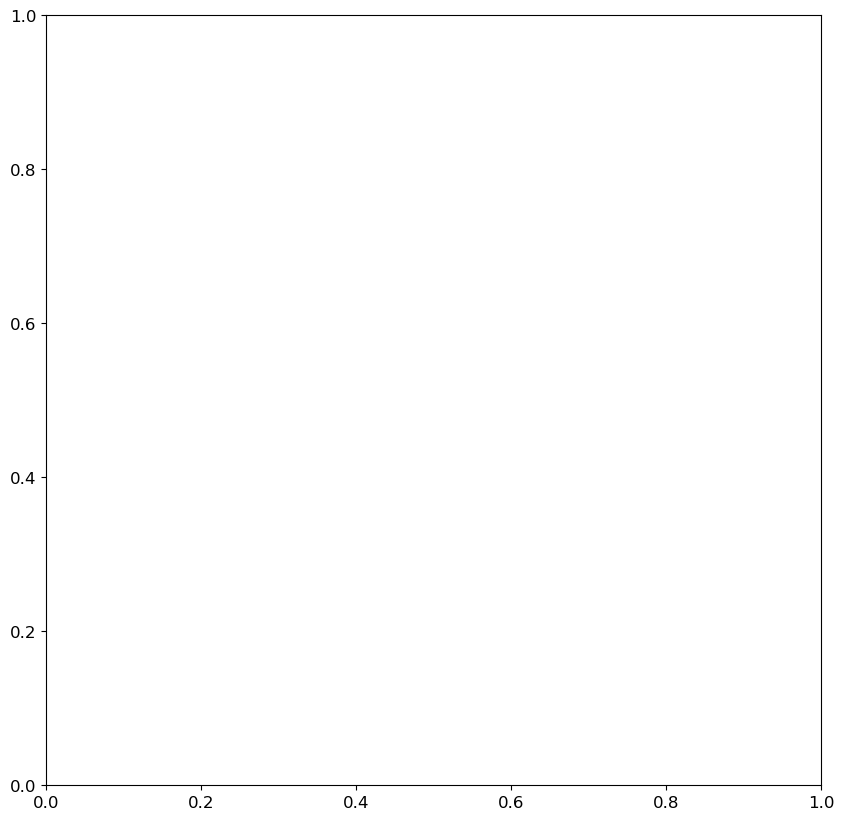

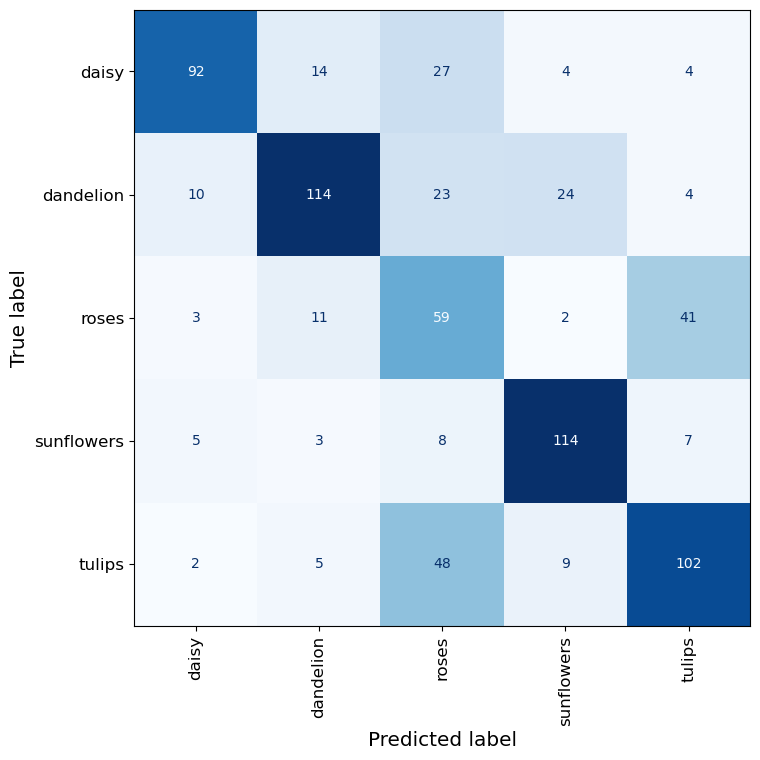

In [42]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
disp  = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap = 'Blues', xticks_rotation='vertical', colorbar=False)
plt.grid(False)
plt.show()

In [44]:
print(f'f1_score: {f1_score(y_true=y_test, y_pred=y_pred, average='weighted'): .4f}')

f1_score:  0.6631
